<div class="alert alert-block alert-info">

----------
---------
# <b> 1. Imports</b> 

--------------
----------------
</div>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import csv
import numpy as np

from torchvision import transforms

from dataset import CorrosionDataset
from model import get_model
import os

from PIL import Image


<div class="alert alert-block alert-info">

----------
---------
# <b> 2. Creating checkpoint directory and training log file</b> 

--------------
----------------
</div>

In [ ]:
save_dir = "../outputs/checkpoints/finetuned_v3" # Creating checkpoint folder
os.makedirs(save_dir, exist_ok=True)

csv_path = f"{save_dir}/training_history_finetuned_v3.csv"# Creating CSV logging file

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "val_loss", "val_iou", "val_dice"])

print("Checkpoint directory created:", save_dir)


Checkpoint directory created: ../outputs/checkpoints/finetuned_v3


<div class="alert alert-block alert-info">

----------
---------
# <b> 3. Preparing datasets with data augmentation and data loaders</b> 

--------------
----------------
</div>

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),     # Resizing images
    transforms.ColorJitter(brightness=0.2, contrast=0.2), #Augmenting images
    transforms.ToTensor() # Converting to tensor
])

train_dataset = CorrosionDataset("../data/train.txt", transform)
val_dataset   = CorrosionDataset("../data/val.txt", transform)
test_dataset  = CorrosionDataset("../data/test.txt", transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Train:", len(train_dataset),
      "Val:", len(val_dataset),
      "Test:", len(test_dataset))


Train: 571 Val: 122 Test: 123


<div class="alert alert-block alert-info">

----------
---------
# <b> 4. Initializing device, model, and fine tuning setup</b> 

--------------
----------------
</div>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model().to(device) # Initializing model

for name, param in model.backbone.named_parameters(): # Freeze only layer1, unfreeze others
    if "layer1" in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

criterion = nn.CrossEntropyLoss() # Defining loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
patience = 20       # increased from 8 → 20
best_val_loss = float("inf")
no_improve = 0

print("Model loaded and backbone partially unfrozen.")


Model loaded and backbone partially unfrozen.


<div class="alert alert-block alert-info">

----------
---------
# <b>5. Evaluation Metrics</b> 

--------------
----------------
</div>

In [5]:
def iou_score(pred, true):
    intersection = (pred & true).sum()
    union = (pred | true).sum()
    if union == 0:
        return 1
    return intersection / union

def dice_score(pred, true):
    intersection = (pred & true).sum()
    return (2 * intersection) / (pred.sum() + true.sum() + 1e-8)


<div class="alert alert-block alert-info">

----------
---------
# <b> 6. Training and Validation Loop</b> 

--------------
----------------
</div>

In [ ]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.train()  # Enabling training mode
    running_loss = 0.0 # Accumulating training loss

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)["out"]

        loss = criterion(outputs, masks) # Computing loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)



    if epoch == 10:           # earlier LR drop
        for param_group in optimizer.param_groups:
            param_group["lr"] = 5e-5
        print("LR reduced to 5e-5 at epoch 10")



    model.eval()
    val_loss_sum = 0.0
    total_iou, total_dice = 0, 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)["out"]
            val_loss_sum += criterion(outputs, masks).item()

            preds = torch.argmax(outputs, dim=1)
            pred_np = preds.cpu().numpy().astype(bool)
            true_np = masks.cpu().numpy().astype(bool)

            total_iou += iou_score(pred_np, true_np)
            total_dice += dice_score(pred_np, true_np)

    val_loss = val_loss_sum / len(val_loader)
    val_iou = total_iou / len(val_loader)
    val_dice = total_dice / len(val_loader)

    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")

    with open(csv_path, "a", newline="") as f:     # Saving to CSV
        writer = csv.writer(f)
        writer.writerow([epoch+1, train_loss, val_loss, val_iou, val_dice])

    torch.save(model.state_dict(),     # Saving model every epoch
               f"{save_dir}/model_epoch_{epoch+1}_finetuned_v3.pth")

    if val_loss < best_val_loss:     # Updating best model
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(),
                   f"{save_dir}/best_model_finetuned_v3.pth")
        print("  Best model updated!")
    else:
        no_improve += 1

    if no_improve >= patience:     # EARLY STOPPING
        print("EARLY STOPPING TRIGGERED!")
        break

print("Training completed.")


Epoch 1/50 | Train Loss: 0.3069 | Val Loss: 0.2099 | IoU: 0.5886 | Dice: 0.7365
  Best model updated!
Epoch 2/50 | Train Loss: 0.1931 | Val Loss: 0.1858 | IoU: 0.5937 | Dice: 0.7409
  Best model updated!
Epoch 3/50 | Train Loss: 0.1564 | Val Loss: 0.1813 | IoU: 0.5911 | Dice: 0.7379
  Best model updated!
Epoch 4/50 | Train Loss: 0.1393 | Val Loss: 0.1768 | IoU: 0.6107 | Dice: 0.7538
  Best model updated!
Epoch 5/50 | Train Loss: 0.1201 | Val Loss: 0.1994 | IoU: 0.5907 | Dice: 0.7336
Epoch 6/50 | Train Loss: 0.1156 | Val Loss: 0.1844 | IoU: 0.6118 | Dice: 0.7533
Epoch 7/50 | Train Loss: 0.1113 | Val Loss: 0.1969 | IoU: 0.5739 | Dice: 0.7227
Epoch 8/50 | Train Loss: 0.0927 | Val Loss: 0.1586 | IoU: 0.6594 | Dice: 0.7910
  Best model updated!
Epoch 9/50 | Train Loss: 0.0818 | Val Loss: 0.1680 | IoU: 0.6422 | Dice: 0.7781
Epoch 10/50 | Train Loss: 0.0749 | Val Loss: 0.1634 | IoU: 0.6529 | Dice: 0.7872
LR reduced to 5e-5 at epoch 10
Epoch 11/50 | Train Loss: 0.0686 | Val Loss: 0.1669 | IoU:

<div class="alert alert-block alert-info">

----------
---------
# <b> 7. Training Curve Visualization</b> 

--------------
----------------
</div>

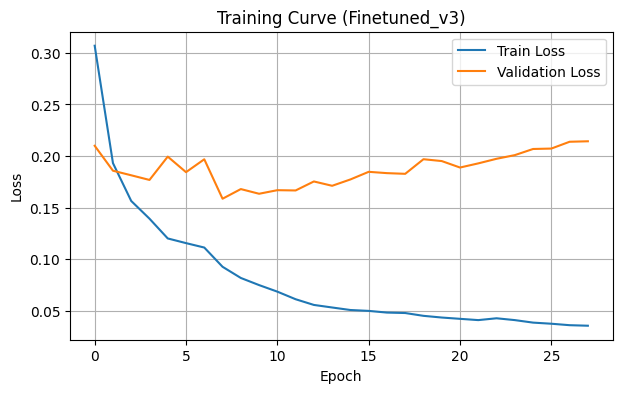

In [8]:
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve (Finetuned_v3)")
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-block alert-info">

----------
---------
# <b>8. Test Set Evaluation</b> 

--------------
----------------
</div>

In [7]:
model.load_state_dict(torch.load(f"{save_dir}/best_model_finetuned_v3.pth"))
model.eval()

ious, dices = [], []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)["out"]
        preds = torch.argmax(outputs, dim=1)

        pred_np = preds.cpu().numpy().astype(bool)
        true_np = masks.cpu().numpy().astype(bool)

        ious.append(iou_score(pred_np, true_np))
        dices.append(dice_score(pred_np, true_np))

print("====================================")
print(" FINAL TEST RESULTS (finetuned_v3) ")
print("====================================")
print("Mean Test IoU :", np.mean(ious))
print("Mean Test Dice:", np.mean(dices))


 FINAL TEST RESULTS (finetuned_v3) 
Mean Test IoU : 0.6686060176560135
Mean Test Dice: 0.7839710899222256


<div class="alert alert-block alert-info">

----------
---------
# <b> 7. Generating predictions using the trained model</b> 

--------------
----------------
</div>

##### **_7.1 Initializing device and loading the trained model_**


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model().to(device)
print("Model created on:", device)


Model created on: cuda


##### **_7.2 Loading  test dataset and data loader_**


In [18]:
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

test_dataset = CorrosionDataset(
    "../data/test.txt",
    transform=test_transform
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Test samples:", len(test_dataset))


Test samples: 123


##### **_7.3 Loading test image filenames_**


In [19]:
test_file = "../data/test.txt"

image_filenames = []
with open(test_file, "r") as f:
    for line in f:
        img_path = line.strip().split()[0]
        image_filenames.append(os.path.basename(img_path))

print("Loaded filenames:", len(image_filenames))


Loaded filenames: 123


##### **_7.4 Creating prediction output directory_**


In [20]:
pred_dir = "../outputs/predictions/finetuned_v3_predictions"
os.makedirs(pred_dir, exist_ok=True)

print("Prediction folder:", pred_dir)


Prediction folder: ../outputs/predictions/finetuned_v3_predictions


##### **_7.5 Loading the best trained model weights for inference_**


In [21]:
save_dir = "../outputs/checkpoints/finetuned_v3"

model.load_state_dict(torch.load(f"{save_dir}/best_model_finetuned_v3.pth"))
model.eval()

print("Best model loaded!")


Best model loaded!


##### **_7.6 Generating and saving test set predictions_**


In [ ]:
index = 0

print("Saving predictions to:", pred_dir)

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)

        outputs = model(images)["out"]
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        pred_mask = preds[0]

        pred_img = (pred_mask * 255).astype(np.uint8)

        # Get original filename
        original_name = image_filenames[index]
        name_no_ext = os.path.splitext(original_name)[0]

        save_path = os.path.join(pred_dir, f"{name_no_ext}_pred.png")
        Image.fromarray(pred_img).save(save_path)

        index += 1

print("Done! Total predictions saved:", index)


Saving predictions to: ../outputs/predictions/finetuned_v3_predictions
Done! Total predictions saved: 123


: 

* Note: The kernel terminated after predictions were successfully saved. This does not affect the generated outputs.